In [1]:
import os, sys
import numpy as np

import scipy
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

### Functions ###

In [2]:
def get_coul_vdW_lambdas(mdpfile):
    """Given an *.mdp file as input, extract the values of coul-lambdas and vdw-lambdas
    
    RETURNS
    coul_lambdas    - numpy array of coul-lambdas
    vdw_lambdas     - numpy array of vdw-lambdas
    
    NOTE: for some specific rpojects, the lambda=0 state is fully coupled,  and lambda=1 is fully uncoupled:         
              couple-lambda0         = vdw-q
              couple-lambda1         = none              
          That means that *first* the coulomb gets turned off, *then* the vdW:
          
    coul-lambdas         = 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0 1.000 1.000 1.000 1.000 ... 1.000 1.0
    vdw-lambdas          = 0.0 0.000 0.000 0.000 0.000 ... 0.000 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0
    """

    fin = open(mdpfile,'r')
    lines = fin.readlines()
    fin.close()

    coul_lambdas, vdw_lambdas = None, None

    for line in lines:
        if line.count('coul-lambdas'):
            coul_string = line.split('=')[1].strip()
            coul_lambdas = np.array([float(s) for s in coul_string.split()])
        elif line.count('vdw-lambdas'):
            vdw_string = line.split('=')[1].strip()
            vdw_lambdas = np.array([float(s) for s in vdw_string.split()])

    return coul_lambdas, vdw_lambdas

In [3]:
def get_fep_lambdas(mdpfile):
    """Given an *.mdp file as input, extract the values of fep-lambdas
    RETURNS
    fep_lambdas      - numpy array of fep-lambdas

    NOTE: for the alchemical transformations, the lambda=0 state is ligand L, and lambda=1 is ligand L*:
        i.e., fep_lambdas  = 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0
    """
    
    fin = open(mdpfile,'r')
    lines = fin.readlines()
    fin.close()

    fep_lambdas = None
    for line in lines:
        if line.count('fep_lambdas'):
            fep_string = line.split('=')[1].strip()
            fep_lambdas = np.array([float(s) for s in fep_string.split()])
            
    return fep_lambdas

In [4]:
def get_dhdl_data(dhdl_xvgfile, verbose=True):
    r"""Read and parse the information in the dhdl file.
    
    RETURNS
    time_in_ps      - time in ps (1D np.array)
    thermo_states   - thermodynamic state indices (1D np.array)
    dhdl            - delta_Uij (np.array of shape (N,K))
                      where N is snapshots and K is number of thermodynamic states
    
    NOTES!!!
    ----> In ABSOLUTE binding free energy calcultions,
    
    time         ---> Column 0 is time in ps.                         
    thermo_index ---> Column 1 = @ s0 legend "Thermodynamic state"
                      Column 2 = @ s1 legend "Total Energy (kJ/mol)"
                      Column 3 = @ s2 legend "dH/d\\xl\\f{} fep-lambda = 0.0000"
                      Column 4 = @ s3 legend "dH/d\\xl\\f{} coul-lambda = 0.0000"
                      Column 5 = @ s4 legend "dH/d\\xl\\f{} vdw-lambda = 0.0000"
    dU_ij starts      Column 6 = @ s5 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0000, 0.0000)"
                      Column 7 = @ s6 legend "\\xD\\f{}H \\xl\f{} to (0.0000, 0.0200, 0.0000)"
                      Column 8 = @ s7 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0400, 0.0000)"
    
    
    ----> In RELATIVE binding free energy calcultions,
    time         ---> Column 0 is time in ps.                         
    thermo_index ---> Column 1 = @ s0 legend "Thermodynamic state"
                      Column 2 = @ s1 legend "Total Energy (kJ/mol)"
                      Column 3 = @ s2 legend "dH/d\xl\f{} fep-lambda = 0.0000"
    
    dU_ij starts ---> Column 4 = @ s3 legend "\xD\f{}H \xl\f{} to 0.0000
                      Column 5 = @ s4 legend "\xD\f{}H \xl\f{} to 0.0020
                      Column 6 = @ s5 legend "\xD\f{}H \xl\f{} to 0.0040
    """
    
    assert os.path.exists(dhdl_xvgfile)

    # Read and parse the file
    fin = open(dhdl_xvgfile,'r')
    lines = fin.readlines()
    fin.close()

    dhdl_column_start = None
    # Read to headers to find which column starts the dhdl data
    for line in lines:
        # Looking for line like this: "@ s5 legend "\xD\f{}H \xl\f{} to (0.0000, 0.0000, 0.0000)"
        # or Looking for line like this: "@ s3 legend "\xD\f{}H \xl\f{} to 0.0000"
        if line.count('"\\xD\\f{}H') > 0:
            dhdl_column_start = int(line.split(' ')[1].replace('s','')) + 1
            break
    if verbose:
        print('dhdl data starts at column:', dhdl_column_start)

    # Get rid of all the header lines
    i = 0
    while i < len(lines):
        if (lines[i][0] == '#') or (lines[i][0] == '@'):
            lines.pop(i)
        else:
            i+=1
            
    # find the correct number of entries from the first line
    ncols = len(lines[0].strip().split())
    print(lines[0])
    print('ncols', ncols)

    time_in_ps, dhdl, thermo_states = [], [], []
    for line in lines:
        line_data_list = [float(s) for s in line.strip().split()]

        # Skip line if it doesn't have the correct number of entries (sometimes the I/O gets cutoff when writing the dhdl.xvg in it corrupts the data)
        if len(line_data_list) == ncols:
            time_in_ps.append(line_data_list[0])
            thermo_states.append(line_data_list[1])
            dhdl.append(line_data_list[dhdl_column_start:])

    time_in_ps = np.array(time_in_ps)
    dhdl = np.array(dhdl)
    thermo_states = np.array(thermo_states)

    return time_in_ps, thermo_states, dhdl

In [5]:
def estimate_sigmas(dhdl, thermo_states, plot_data=True):
    """Using as input the Delta_U_ij energies from the dhdl array, 
    estimate the standard deviations P(U_{i-->i+1}) for neighboring ensembles.
    
    RETURNS
    sigmas   - a np.array() of standard deviations P(U_{i-->i+1}).
    """

    nlambdas = dhdl.shape[1]
    Delta_uij_values = []
    sigmas = []
    
    if plot_data:
        plt.figure(figsize=(6, 12))
    
    for j in range(nlambdas-1):

        ##transitions from state 0 to 1 or 1 to 2, or 2 to 3 .... 
        Ind_i = (thermo_states == j)
        delta_u_ij = dhdl[Ind_i, j+1]       ##only for neighbored ensembles

        #Delta_uij_values.append(delta_u_ij)

        mu, sigma = scipy.stats.norm.fit(delta_u_ij)
        sigmas.append(sigma)
        
        delta_u_bins = np.arange(-100., 100., 0.2)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        if plot_data:
            plt.subplot(nlambdas-1, 1, j+1)
            plt.step(bin_centers, counts, label='$\Delta u_{%d \\rightarrow %d} \sigma$=%.2f'%(j,j+1,sigma))
            #plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j, j+1))
            plt.legend(loc='best')

    if plot_data:
        plt.tight_layout()
        plt.show()

    return np.array(sigmas)

In [6]:
def opt_lambdas(sigmas, cal_type, nsteps =100000, tol =1e-7, alpha =1e-5, 
                print_every =250, make_plots=False):   #cal_type = 'absolute'(having coul and vdw) or 'relative' (only having fep lambdas)

    print('sigmas', sigmas)
                  
    ### Lambda optimization
    dx = sigmas                 #according to the equation (VAV: k is set to 1)

    x_values = np.cumsum(dx)    # convert to a list of x values of separated harmonic potentials
    x_values = np.array(np.concatenate([[0], x_values]))    # add a zero corresponding to lambda0 = 0.0
    print('x_values', x_values)

    if make_plots:
        plt.figure(figsize=(12,6))

                
    lambda_values = lambdas         #not inclduing the first one, lambda_0 

    x_observed = lambda_values      #not inclduing the first one, lambda_0
    y_observed = x_values
                
    if make_plots:
        plt.subplot(1,2,1)
        plt.plot(x_observed, y_observed, 'ro', label = 'data')
        #plt.semilogy(x_observed, y_observed, 'ro', label = 'data')
     #y_spl = CubicSpline(x_observed, y_observed)#, s=0,k=4)  
    y_spl = UnivariateSpline(x_observed, y_observed, s=0, k=3)
    x_range = np.linspace(x_observed[0], x_observed[-1], 1000)
        
    if make_plots:
        plt.plot(x_range, y_spl(x_range), label="spline")   # for UnivariateSpline
        ## plt.plot(x_observed, y_spl(x_observed), label="spline") # for CubicSpline
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('x values')
            
        plt.subplot(1,2, 2)   #derivative plot   
 
    y_spl_1d = y_spl.derivative(n=1)    #n=1 , means the first order derivative
    # y_spl_1d = y_spl(x_observed, 1)  # first derivative of Cubic spline
                
    if make_plots:
        plt.plot(x_range, y_spl_1d(x_range), '-')
        plt.plot(x_observed, y_spl_1d(x_observed), '.')
        plt.ylabel('dx/dlambda')
                         
                
    # Let's try a steepest descent algorithm: run the algorithm some fixed number of steps, or until some tolerance is reached
    #nsteps = 100000
    #tol = 1e-7  # stop if the lambdas dont change within this tolerance

    #alpha = 1e-5  # gradient descent step size
    max_del_lambda = 0.0001   # the minimization step limited to this as a maximum change

    VERBOSE = False
    #print_every = 250

    nlambdas = len(lambda_values)
    print('lambda_values', lambda_values)
    old_lambdas = np.array(lambda_values)
    traj_lambdas = np.zeros( (nlambdas,nsteps) )
    for step in range(nsteps):
        # store the trajectory of lambdas
        traj_lambdas[:,step] = old_lambdas
        if VERBOSE:
            print('step', step, old_lambdas)

        # perform a steepest descent step
        new_lambdas = np.zeros( old_lambdas.shape )
        del_lambdas = np.zeros( old_lambdas.shape )
        del_lambdas[0] = 0.0   # fix the \lambda = 0 endpoint
        del_lambdas[nlambdas-1] = 0.0  # fix the \lambda = 1 endpoint
                
        if False:  # do in a loop (SLOW!) 
            for i in range(1, (nlambdas-1)):
                del_lambdas[i] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[i])*( 2.0*y_spl(old_lambdas[i]) - y_spl(old_lambdas[i-1]) - y_spl(old_lambdas[i+1]))
        else:   # do as a vector operation (FAST!) 
            y_all = y_spl(old_lambdas)
            yh, yi, yj = y_all[0:nlambdas-2], y_all[1:nlambdas-1], y_all[2:nlambdas]
            del_lambdas[1:nlambdas-1] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[1:nlambdas-1])*( 2.0*yi - yh - yj)
        if abs(np.max(del_lambdas)) > max_del_lambda:
            del_lambdas[1:nlambdas-1] = del_lambdas[1:nlambdas-1]*max_del_lambda/np.max(del_lambdas)
        new_lambdas = old_lambdas + del_lambdas

        # record the average change in the lambdas 
        del_lambdas = np.abs(old_lambdas - new_lambdas).mean()
        if step % print_every == 0:
            print('step', step, 'del_lambdas', del_lambdas)
        if del_lambdas < tol:
            print('Tolerance has been reached: del_lambdas =', del_lambdas, '< tol =', tol)
            break

        old_lambdas = new_lambdas
                
    if make_plots:
        # Plot the results
        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        for i in range(nlambdas):
            plt.plot(range(step), traj_lambdas[i,0:step], '-')
        plt.xlabel('step')
        plt.ylabel('lambda values')

        plt.subplot(1,2,2)
        for i in range(nlambdas):
            plt.plot(range(step), y_spl(traj_lambdas[i,0:step]), '-')
        plt.xlabel('step')
        plt.ylabel('x values')
                
    if make_plots:

        plt.figure(figsize=(12,4))

        plt.subplot(2,1,1)
        plt.plot(x_range, y_spl(x_range), 'b-', label="spline")
        plt.plot(lambda_values, y_spl(np.array(lambda_values)), 'r.', label="old lambdas")
        for value in lambda_values:
            plt.plot([value, value], [0, y_spl(value)], 'r-')
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('x values')
        plt.title('old lambdas')

        plt.subplot(2,1,2)
        plt.plot(x_range, y_spl(x_range), 'b-', label="spline")
        plt.plot(new_lambdas, y_spl(new_lambdas), 'g.', label="new lambdas")
        for value in new_lambdas:
            plt.plot([value, value], [0, y_spl(value)], 'g-')
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('x values')
        plt.title('new lambdas')
                
    if cal_type == 'absolute':
        # Finally, we transform the [0,2] coul+vdW interval back to separate coul_lambdas and vdw_lambdas
        new_coul_lambdas = np.minimum(new_lambdas, np.ones(new_lambdas.shape))
        new_vdw_lambdas  = np.maximum(new_lambdas, np.ones(new_lambdas.shape)) - 1.0

        # print out the new lambdas as if they were in an mdp file
        outstring = 'coul-lambdas    = ' + " ".join(['%1.4f'%lam for lam in new_coul_lambdas])
        print(outstring)

        outstring = 'vdw-lambdas     = ' + " ".join(['%1.4f'%lam for lam in new_vdw_lambdas])
        print(outstring)
    
    if cal_type == 'relative':
        # finally, print out new fep-lambdas
        outstring = 'fep_lambdas               =' + " ".join(['%1.4f'%lam for lam in new_lambdas])
        print (outstring)
    

### Optimizing ###

old lambdas [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
dhdl data starts at column: 4
0.0000    0 -64162.258 1660.5419 0.0000000 119.13556 189.24114 236.67659 271.72306 301.07562 332.44853 381.05734 492.62519 909.37491 57878.600

ncols 15
time_in_ps [0.000000e+00 5.000000e-01 1.000000e+00 ... 1.016835e+05 1.016840e+05
 1.016845e+05]
thermo_states [0. 0. 0. ... 7. 8. 8.]


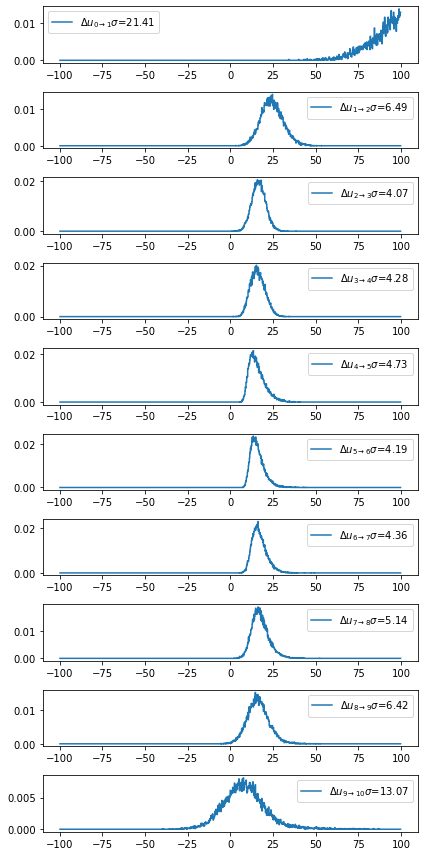

[21.40904777  6.48927975  4.06601959  4.27966311  4.73429344  4.19212391
  4.35657087  5.14423844  6.4248839  13.07139905]
sigmas [21.40904777  6.48927975  4.06601959  4.27966311  4.73429344  4.19212391
  4.35657087  5.14423844  6.4248839  13.07139905]
x_values [ 0.         21.40904777 27.89832751 31.96434711 36.24401022 40.97830366
 45.17042756 49.52699843 54.67123687 61.09612077 74.16751982]
lambda_values [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
step 0 del_lambdas 4.033003031760831e-05
step 250 del_lambdas 3.622844313554709e-05
step 500 del_lambdas 5.31868353436092e-05
step 750 del_lambdas 5.6570737877951396e-05
step 1000 del_lambdas 6.068275721801371e-05
step 1250 del_lambdas 0.00013854976108219864
step 1500 del_lambdas 4.502544099155828e-05
step 1750 del_lambdas 4.379730842345164e-05
step 2000 del_lambdas 2.882027707448594e-05
step 2250 del_lambdas 5.1631833556207225e-06
step 2500 del_lambdas 1.2457135465850783e-05
step 2750 del_lambdas 1.4756601230910309e-05
step 3000 del_lam

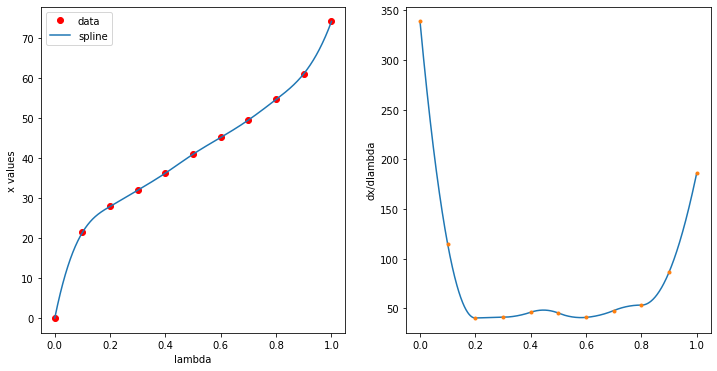

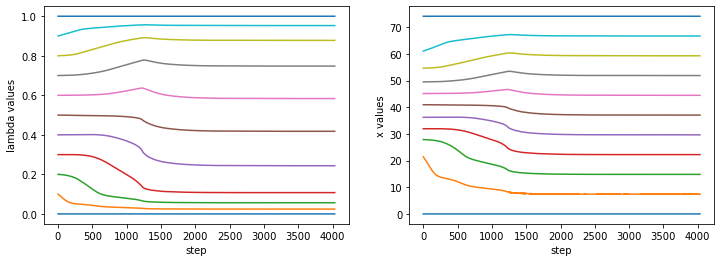

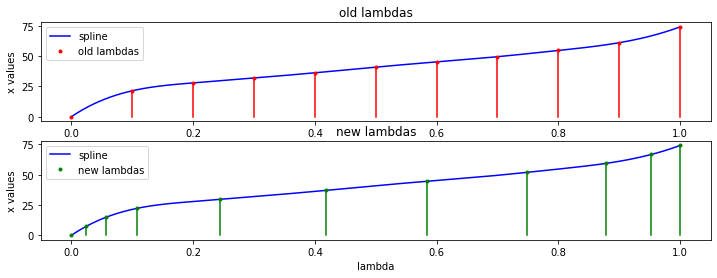

In [7]:
#EE_type = ['relative', 'absolute']

EE_type = 'relative'

mdpfile = 'relative_EE/example_data/ee_Si.mdp'
dhdl_xvgfile = 'relative_EE/example_data/equil_1.xvg'
#sel_lines_dhdl = 1000

if EE_type == 'absolute':
    coul_lambdas, vdw_lambdas = get_coul_vdW_lambdas(mdpfile)

    # We map each [0,1] set of values to the interval [0,2] by elemenet-wise summing of the two sets of values
    lambdas = coul_lambdas + vdw_lambdas
    print('old lambdas', lambdas)
    
if EE_type == 'relative':
    fep_lambdas = get_fep_lambdas(mdpfile)
    # We map each [0,1] set of values to the intervals
    lambdas = fep_lambdas
    print('old lambdas', lambdas)

time_in_ps, thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile)
print('time_in_ps', time_in_ps)
print('thermo_states', thermo_states)
#print('dhdl', dhdl)

sigmas = estimate_sigmas(dhdl, thermo_states, plot_data=True)
print (sigmas)

new = opt_lambdas(sigmas, EE_type, make_plots=True)

### can modify nsteps, tol, alpha, print_every here
#new = opt_lambdas(sigmas, EE_type, make_plots=True, nsteps =100000, tol =1e-7, alpha =1e-5, print_every =250) 